### Demonstration of Quantum Key Distribution with the Ekert 91 Protocol

Algorithm -
1. First generate the a maximally entangled qubit pair |psi+> = 1/root(2) * (|01> + |10>)
2. Send one qubit to Alice and one qubit to Bob
3. Both Alice and Bob perform their measurement and make the measurement bases public.
4. According to the new information obtained, a sifted key is created, which can be used for secure communication

Modification to this Algorithm (because we get only 1 quantum computer) -
1. First generate the a maximally entangled qubit pair |psi+> = 1/root(2) * (|01> + |10>)
2. Take the measurement bases from Alice and Bob
3. Perform measurement, and send the measurement results to Alice and Bob respectively
4. Note that Alice and Bob do not have each other's measurement outcomes, they have only theirs
5. The measurement bases are made public, and the sifted key is obtained

In [9]:
import os
from qiskit import execute
from qiskit.circuit import QuantumRegister, ClassicalRegister, QuantumCircuit

from quantuminspire.credentials import get_authentication, enable_account
from quantuminspire.qiskit import QI
import re 
from apikey import token

import numpy as np
import random
print("Process Complete!")

Process Complete!


<a id="layout"></a>
# 1. Quantum Key Distribution Activity layout

In project, we are going to implement the E91 protocol. Steps of the protocol:

1. The serves creates a singlet state where one pair corresponds to Alice and other to Bob.
2. Alice randomly selects a sequence of measurement basis from Z,X,V and sends it to server
3. Bob randomly selects a sequence of measurement basis from W,V,X and sends it to server
4. `Intermediate interface function 1`: a MUX that creates a circuit based on Alice and Bob's selection of bases
5. `Intermediate interface function 2`: execute the measurement on Quantum Inspire 
6. `Intermediate interface function 3`: send back measurement results to Alice and Bob
7. `ANNOUNCE BASIS`: Alice announces which basis she used to encode each bit, via the classical channel.

7. `FIND SYMMETRIC KEY`: Alice and Bob discard bits in their key that used a different basis.

These 7 steps allow a key to be distributed between Alice and Bob securely, now the two can send secure and encrypted messages through an insecure channel. 

In this lab, we will not worry about an eavesdropper, but focus on the code for the basic protocol. Therefore, Alice and Bob don't need to run an analysis step. We can further extend it this to try implementing code for Eve.

In [10]:
# Init
N_en_pairs = 10
alice_seq = [random.randint(1, 3) for i in range(N_en_pairs)]
bob_seq = [random.randint(1, 3) for i in range(N_en_pairs)]
print("Process Complete!")

Process Complete!


<a id="layout"></a>
## 1. Create entangled states and encode measurement sequence

In [4]:
Quantum_Circuit = [] # list for storing the quantum circuit for each bit

for i in range(N_en_pairs):
    Alice_Reg = QuantumRegister(1, name="alice")
    Bob_Reg = QuantumRegister(1, name="bob")
    cr = ClassicalRegister(2, name="cr")
    qc = QuantumCircuit(Alice_Reg, Bob_Reg, cr)
    
    q = QuantumRegister(2)
    b = ClassicalRegister(2)
    qc = QuantumCircuit(q, b)
    
    # Create an entangled pair for Alice and Bob in each loop
    qc.x(Alice_Reg)
    qc.x(Bob_Reg)
    qc.h(Alice_Reg)
    qc.cx(Alice_Reg, Bob_Reg)
    
    # Cicuit Measurement for different bases
    
    if alice_seq[i]== 1:            #If Alice's random sequence is 1, Alice measures in the Z basis
        qc.measure(Alice_Reg,cr[0])  
    elif alice_seq[i] == 2:         #If Alice's random sequence is 2, Alice measures in the X basis
        qc.h(Alice_Reg)
        qc.measure(Alice_Reg,cr[0])
    elif alice_seq==3:              #If Alice's random sequence is 3, Alice measures in the V basis (-1/sqrt(2), 0, 1/sqrt(2))
        qc.s(Alice_Reg)
        qc.h(Alice_Reg)
        qc.tdg(Alice_Reg)
        qc.h(Alice_Reg)
        qc.measure(Alice_Reg, cr[0])
        
    if bob_seq[i]==1:               #If  Bob's random sequence is 1, Bob measures in the -W basis
        qc.s(Bob_Reg)
        qc.h(Bob_Reg)
        qc.t(Bob_Reg)
        qc.h(Bob_Reg)
        qc.measure(Bob_Reg, cr[1])
    elif bob_seq[i] == 2:           #If  Bob's random sequence is 2, Bob measures in the V basis
        qc.s(Bob_Reg)
        qc.h(Bob_Reg)
        qc.tdg(Bob_Reg)
        qc.h(Bob_Reg)
        qc.measure(Bob_Reg, cr[1])
    elif bob_seq[i] == 3:           #If  Bob's random sequence is 3, Bob measures in the X basis
        qc.h(Bob_Reg)
        qc.measure(Bob_Reg, cr[1])

    
    Quantum_Circuit.append(qc)

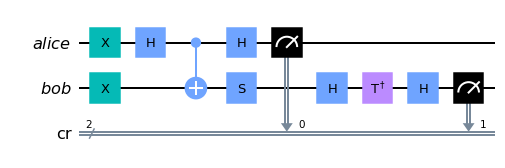

In [5]:
Quantum_Circuit[0].draw(output='mpl')


## To QI

In [6]:

enable_account(token)
project_name = 'E91_test_hardware'
authentication = get_authentication()
QI.set_authentication(authentication, QI_URL, project_name=project_name)
# Create an interface between Qiskit and Quantum Inpsire to execute the circuit
qi_backend = QI.get_backend('Starmon-5')
job = execute(Quantum_Circuit, qi_backend, shots = 1)

In [7]:
results = job.result()
counts = results.get_counts()

ApiError: Job with id 7127017 does not exist!

In [ ]:
abPatterns = [
    re.compile('00'), # search for the '..00' output (Alice obtained -1 and Bob obtained -1)
    re.compile('01'), # search for the '..01' output
    re.compile('10'), # search for the '..10' output (Alice obtained -1 and Bob obtained 1)
    re.compile('11')  # search for the '..11' output
]

### Alices and Bobs measurement result

In [ ]:
aliceResults = [] # Alice's results (string a)
bobResults = [] # Bob's results (string a')

for i in range(N_en_pairs):

    res = list(counts[i].keys())[0] # extract the key from the dict and transform it to str; execution result of the i-th circuit
    
    if abPatterns[0].search(res): # check if the key is '..00' (if the measurement results are -1,-1)
        aliceResults.append(-1) # Alice got the result -1 
        bobResults.append(-1) # Bob got the result -1
    if abPatterns[1].search(res):
        aliceResults.append(1)
        bobResults.append(-1)
    if abPatterns[2].search(res): # check if the key is '..10' (if the measurement results are -1,1)
        aliceResults.append(-1) # Alice got the result -1 
        bobResults.append(1) # Bob got the result 1
    if abPatterns[3].search(res): 
        aliceResults.append(1)
        bobResults.append(1)

### Key Generation

In [ ]:
aliceKey = [] # Alice's key string k
bobKey = [] # Bob's key string k'

# comparing the strings with measurement choices
for i in range(N_en_pairs):
    # if Alice and Bob have measured the spin projections onto the a_2/b_3 or a_3/b_2 directions
    if (alice_seq[i] == 2 and bob_seq[i] == 3) or (alice_seq[i] == 3 and bob_seq[i] == 2):
        aliceKey.append(aliceResults[i-1]) # record the i-th result obtained by Alice as the bit of the secret key k
        bobKey.append(- bobResults[i-1]) # record the multiplied by -1 i-th result obtained Bob as the bit of the secret key k'
        print(i)
        
keyLength = len(aliceKey) # length of the secret key

In [ ]:
abKeyMismatches = 0 # number of mismatching bits in Alice's and Bob's keys

for j in range(keyLength):
    if aliceKey[j] != bobKey[j]:
        abKeyMismatches += 1

In [ ]:
bobKey

In [ ]:
aliceKey

In [ ]:
abKeyMismatches

In [ ]:
aliceResults

In [ ]:
bobResults

In [ ]:
alice_seq

In [ ]:
bob_seq